# _Long Only Portfolio_

The following notebook will introduce you to a simple performance analyses of our long only strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the SPX and fees are applied annually. 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

    The csv file contains the following series:
        - SPX Returns 
        - Real Portfolio Returns
        - Predicted ML Returns
    

In [11]:
data= pd.read_csv("../data/long_only_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['sp500'] = data['sp500']/100
data['effectif'] = data['effectif']/100
data['prediction'] = data['prediction']/100
data.head()

,sp500,effectif,prediction,date
0,-0.001047,0.053932,0.036979,2011-03-01
1,0.028495,0.035936,0.033756,2011-04-01
2,-0.013501,0.004969,0.029150,2011-05-01
3,-0.018257,0.007212,0.030575,2011-06-01
4,-0.021474,-0.014186,0.038480,2011-07-01


_Our Portfolio on average outperforms the benchmark with a lower standard deviation (fees not included)._
    
_By the rule of thumb if the skewness is between -0.5 and 0.5, the data are fairly symmetrical ; if the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed ; if the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed. SPX is positively skewed, but our portfolio is sim-neg skewed, the reason why we beat our benchmark._

_Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. A large kurtosis is associated with a high level of risk of an investment because it indicates that there are high probabilities of extremely large and extremely small returns. On the other hand, a small kurtosis signals a moderate level of risk because the probabilities of extreme returns are relatively low. 
Note: Scipy Kurtosis is calculated using the the Fisher methods which compares our Kurtosis with the normal one. So the result is calculated using Kurt - 3. Our portfolio has less extreme events compared to the normal one and the SPX has more extreme ones._
    
_All the results will be better shown below._
    

In [70]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['SPX', str(round(data['sp500'].mean()*100,2))+'%', str(round(data['sp500'].std()*100,2))+'%',
             str(round(kurtosis(data['sp500']),2))+'%',  str(round(skew(data['sp500']),2))+'%'], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2))+'%',  str(round(skew(data['effectif']),2))+'%'
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['sp500'].mean()*100),5)) 
print('The Excess Returns of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark')

+-----------+-------------+-------+----------+----------+
|  Series   | Mean Return |  Std  | Kurtosis | Skewness |
+===========+=============+=======+==========+==========+
| SPX       | 0.88%       | 3.38% | 0.87%    | -0.35%   |
+-----------+-------------+-------+----------+----------+
| Portfolio | 1.28%       | 2.8%  | -0.29%   | -0.14%   |
+-----------+-------------+-------+----------+----------+
The Excess Returns of our Portfolio on average is: 0.4% compared to our benchmark



- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: 49.7%


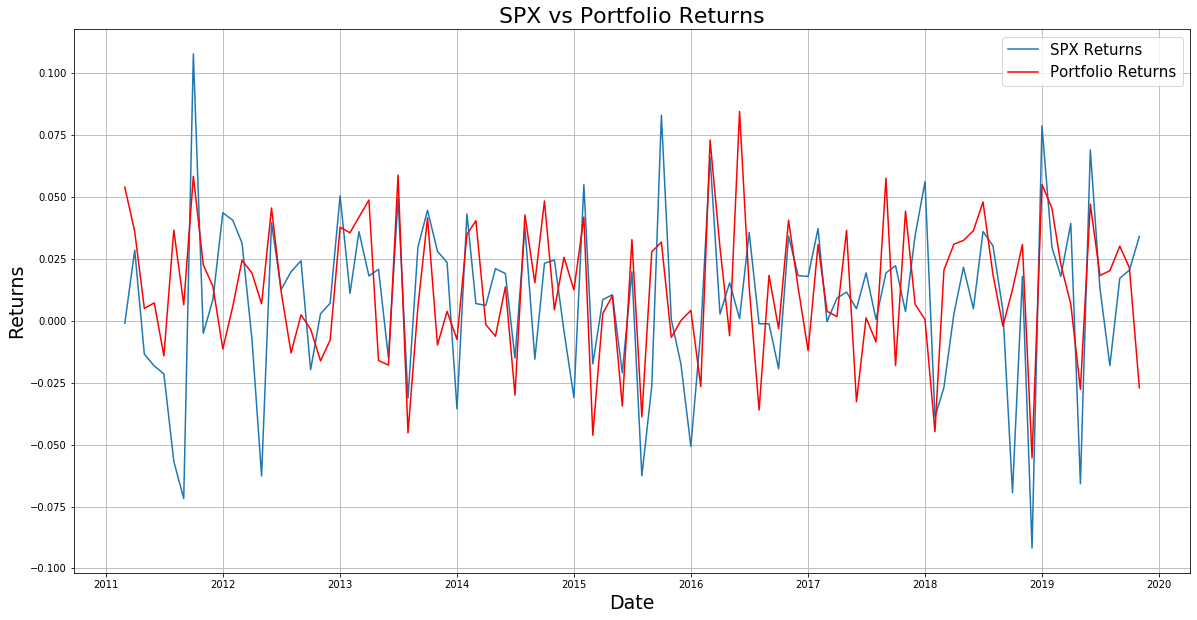

In [13]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.sp500, label='SPX Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

plt.title('SPX vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()


- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: 49.7%


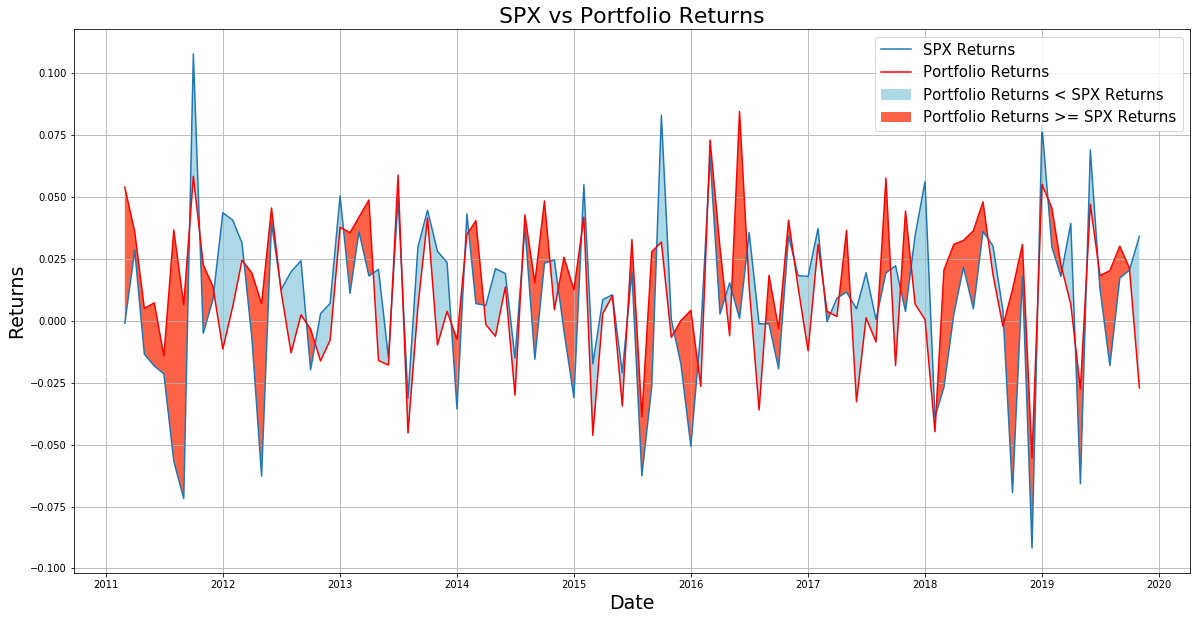

In [14]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.sp500, label='SPX Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above SP, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < SPX Returns")
plt.fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] <= data["effectif"]
                , facecolor= "tomato"
                , interpolate= True
                , label= "Portfolio Returns >= SPX Returns")


plt.title('SPX vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

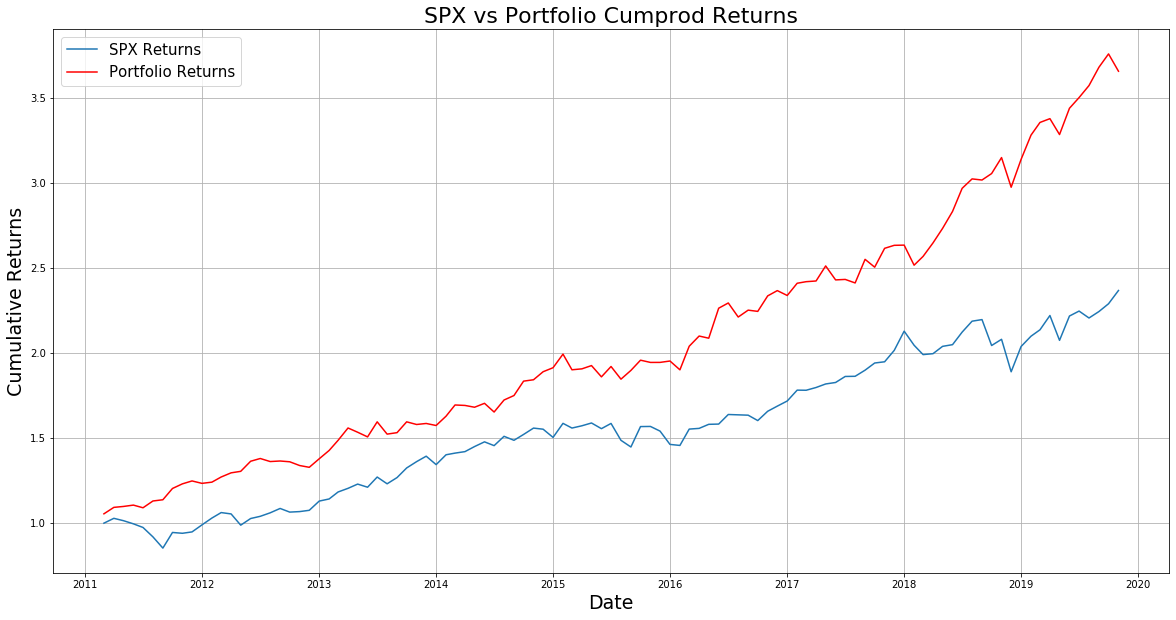

In [15]:
plt.figure(figsize=(20,10))
plt.plot(data.date,(1+data['sp500']).cumprod(),label='SPX Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns')
plt.title('SPX vs Portfolio Cumprod Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

In [16]:
t = Texttable()
t.add_rows([['Series', 'Total Return'], 
            ['SPX', str(round(list((1+data['sp500']).cumprod())[-1]-1,3)*100)+'%'] ,
            
            ['Portfolio',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%'
            ]])
print(' Results in Cumulative Return')
print(t.draw())

 Results in Cumulative Return
+-----------+--------------+
|  Series   | Total Return |
+===========+==============+
| SPX       | 136.7%       |
+-----------+--------------+
| Portfolio | 265.5%       |
+-----------+--------------+


In [17]:
# cumulative_ret_port = (data['effectif']/100 + 1).cumprod()
# cumulative_ret_SPX = (data['sp500']/100 + 1).cumprod()
# plt.figure(figsize=(20,10))
# plt.plot(data.date, list(cumulative_ret_SPX),label='SPX Returns')
# plt.plot(data.date, list(cumulative_ret_port), c='r', label='Portfolio Returns')
# plt.title('SPX vs Portfolio CumProd Returns', size = 22)
# plt.xlabel('Date', fontsize=19)
# plt.ylabel('Cumulative Returns', fontsize=19)
# plt.legend(prop={'size': 15})
# plt.grid()
# plt.show()

<Figure size 720x504 with 0 Axes>

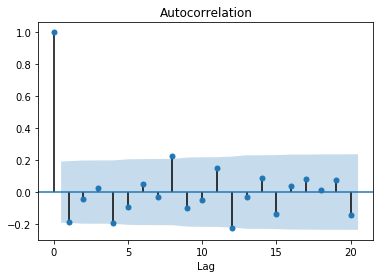

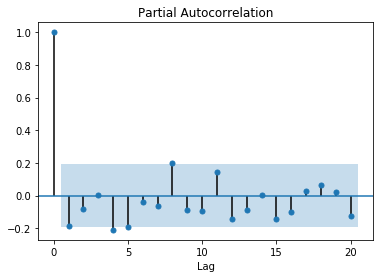

In [19]:
# Autocorrelation for all periods (with confidence intervals)

plt.figure(figsize=(10,7))

plot_acf(data["effectif"], lags= 20)
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 20)
plt.xlabel("Lag")

plt.show()

In [24]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Fréquence", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

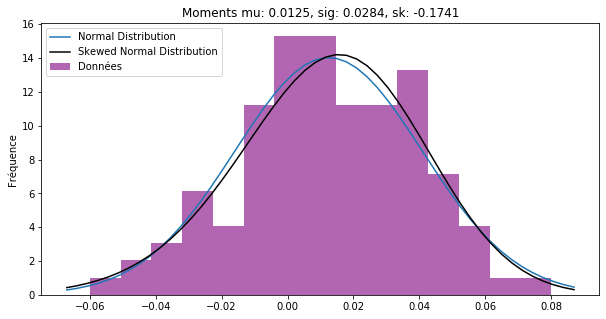

In [33]:
# Our portfolio returns
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 2) for val in data["effectif"].values], bins= 15)

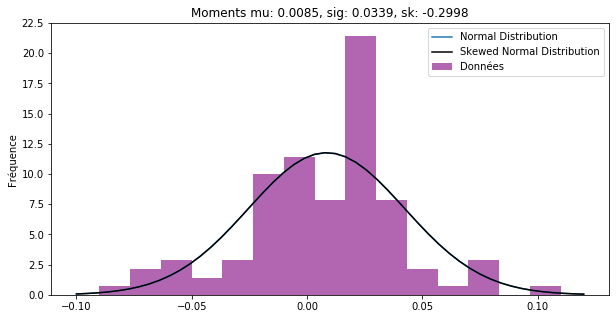

In [29]:
# SPX distribution
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 2) for val in data["sp500"].values], bins= 15)

In [34]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["sp500"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["sp500"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["sp500"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

C:\Users\geril\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # Remove the CWD from sys.path while we load stuff.
C:\Users\geril\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


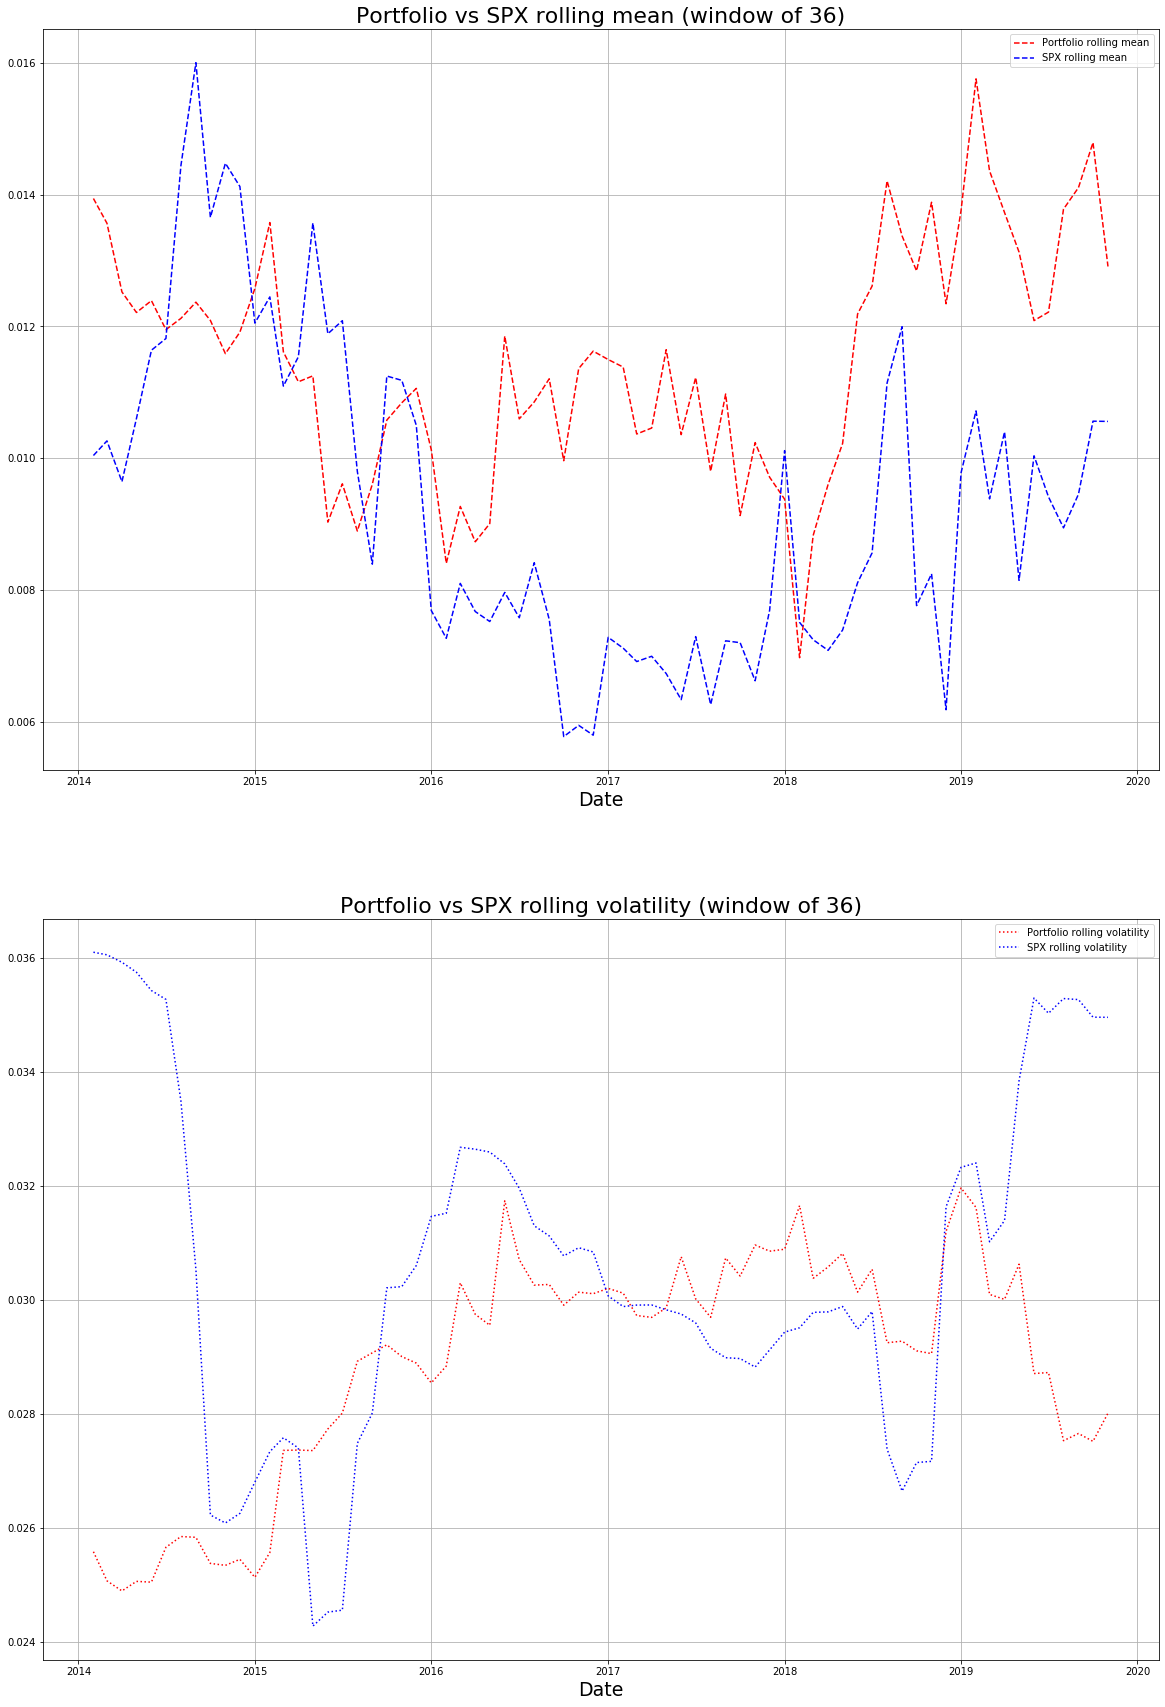

In [36]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (20, 30))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs SPX rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 22)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= ":", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= ":", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 22)

# Rolling autocorr ????



for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 19)
    ax[i].grid()
    ax[i].legend()

plt.show()

In [95]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Series', 'Alpha' , 'Beta'], 
            ['SPX', str(round(alpha,2))+' %',str(round(beta,2))+' %']])
        print(t.draw())
    else:
        return alpha, beta
print('The results are shown for the entire period')
alpha_beta(data["sp500"].values, data["effectif"].values)

The results are shown for the entire period
+--------+--------+--------+
| Series | Alpha  |  Beta  |
+========+========+========+
| SPX    | 0.01 % | 0.41 % |
+--------+--------+--------+


In [96]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [143]:
roll_alpha = []
roll_beta = []
n = 36

for be, al in zip((windows(data["sp500"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


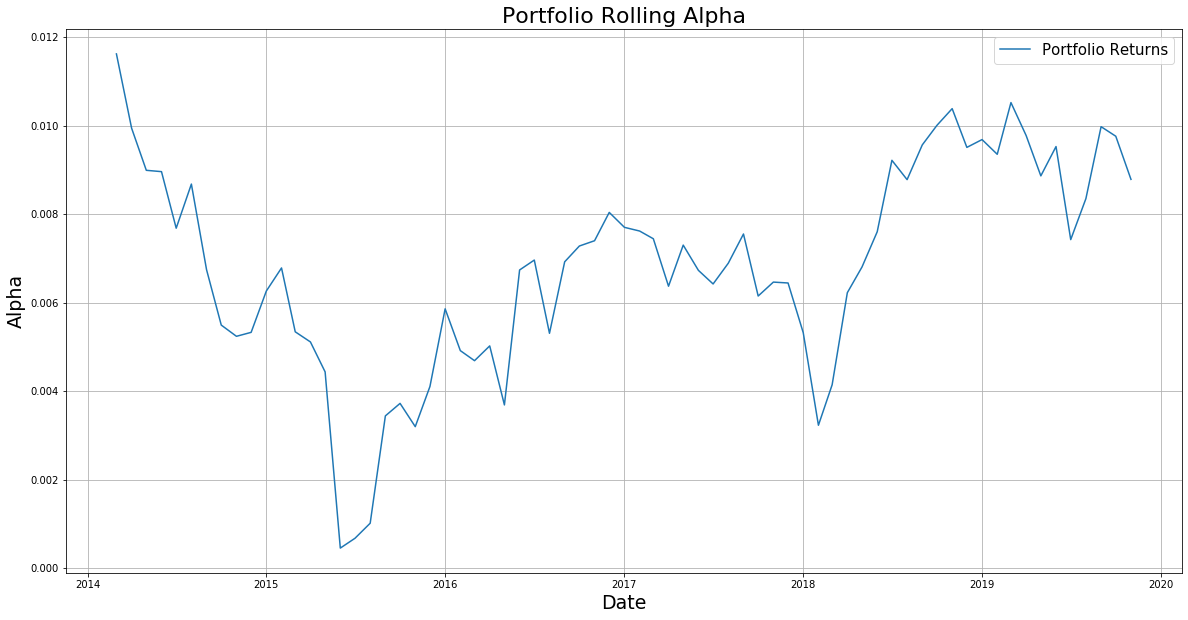

In [144]:
plt.figure(figsize=(20,10))
plt.plot(data.date.values[-len(roll_alpha):], roll_alpha, label='Portfolio Returns')

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36


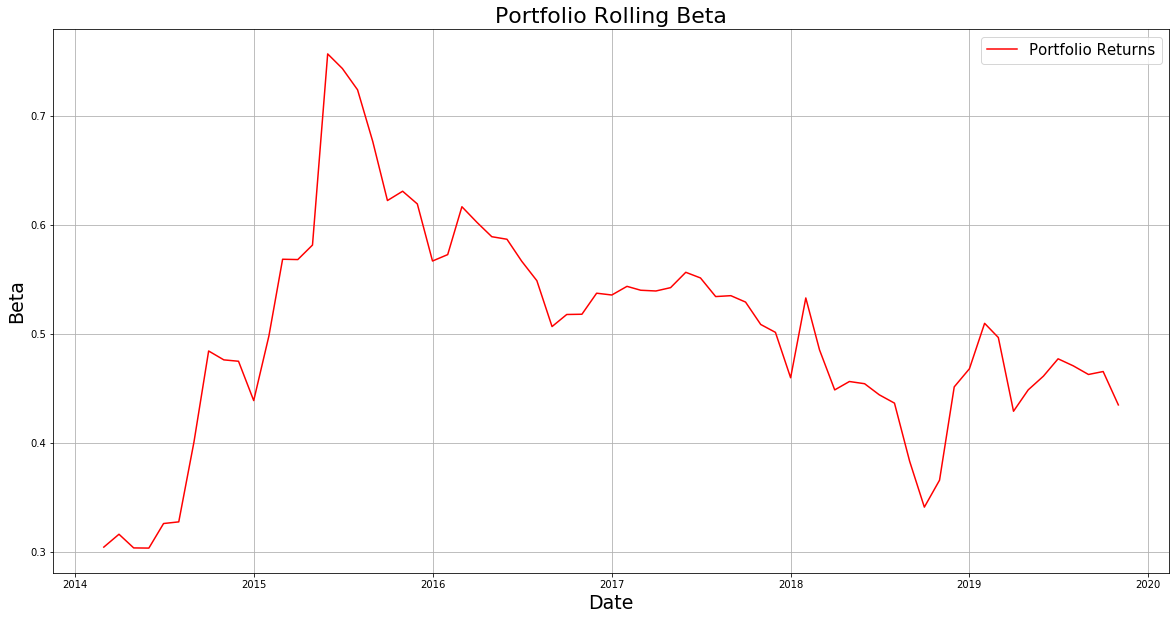

In [145]:
plt.figure(figsize=(20,10))
plt.plot(data.date.values[-len(roll_beta):], roll_beta, label='Portfolio Returns',c ='r')

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the rolling Beta with a window of 36')
plt.show()